## Preparation
Make the file structure:

In [1]:
import os, shutil

base_dir = 'data_small'

def rm_dir(my_dir):
    if os.path.exists(my_dir):
        shutil.rmtree(my_dir)

rm_dir(base_dir)

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

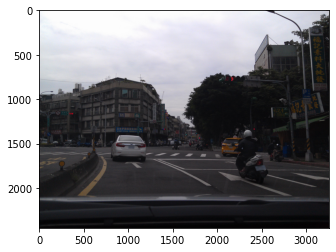

Shape: (2448, 3264, 3)


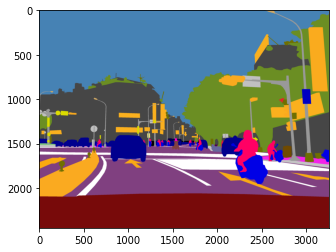

Shape: (2448, 3264, 3)


In [3]:
from keras import utils
import matplotlib.pyplot as plt

def get_first(my_dir):
    file_name = os.listdir(my_dir)[0]
    image = utils.load_img(os.path.join(my_dir, file_name))
    return image

def show_first(my_dir):
    image = get_first(my_dir)
    image = utils.img_to_array(image)
    image /= 255
    
    plt.imshow(image)
    plt.show()
    print('Shape: ' + str(image.shape))

show_first(train_x_dir)
show_first(train_y_dir)

## Encoding

Let's integer-encode the categories of a label:

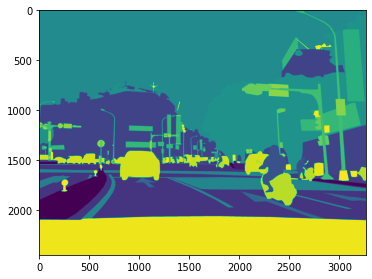

In [6]:
import json
import numpy as np
from keras import layers
import tensorflow as tf

config_file = open('data/config_v2.0.json')
config = json.load(config_file)
cats_to_colors = list(map(lambda x: x['color'], config['labels']))
# resizer = layers.Resizing(input_height, input_width, interpolation='nearest')

def to_cats(colors):
    cats = np.zeros((colors.shape[0], colors.shape[1]))
    
    for i in range(len(cats_to_colors)):
        color = cats_to_colors[i]
        mask = np.all(label == color, axis=2)
        cats[mask] = i
    
    return cats.astype(int)

label = get_first(train_y_dir)
label = utils.img_to_array(label)
# label = resizer(label)
label = to_cats(label)
# label = tf.cast(label, int)
# print(label)

fig, ax = plt.subplots(figsize=(6, 6 * label.shape[0] / label.shape[1]))
ax.imshow(label)
plt.show()

## Naive Autoencoder

In [ ]:
from keras import models
from keras import optimizers
from keras import backend

input_width = 512
input_height = 512
input_shape = (input_width, input_height, 3)
num_f_maps_0 = 8

encoder = models.Sequential()
encoder.add(layers.Conv2D(num_f_maps_0, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_f_maps_0 * 2, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_f_maps_0 * 4, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()

decoder.add(layers.Conv2DTranspose(
    num_f_maps_0 * 2,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu',
    input_shape=(input_width // 8, input_height // 8, num_f_maps_0 * 4)))

decoder.add(layers.Conv2DTranspose(num_f_maps_0, kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='softmax'))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()
backend.clear_session()

Let's start training:

In [ ]:
batch_size = 20
num_epochs = 16
normalizer = layers.Rescaling(1./255)

# def get_dataset(my_dir):
#     dataset = utils.image_dataset_from_directory(
#         my_dir,
#         labels=None,
#         batch_size=batch_size,
#         image_size=(input_height, input_width),
#         shuffle=False
#     )
    
# #     dataset = dataset.map(lambda x: normalizer(x))
#     return dataset

# train_x_dataset = get_dataset(train_x_dir).map(lambda x: normalizer(x))
# train_y_dataset = get_dataset(train_y_dir).map(lambda x: to_cats(x))

train_x_dataset = utils.image_dataset_from_directory(
    train_x_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False
#     interpolation='nearest'
)

train_y_dataset = utils.image_dataset_from_directory(
    train_y_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False,
    interpolation='nearest'
)

train_gen = zip(train_x_dataset.repeat(), train_y_dataset.repeat())

val_x_dataset = get_dataset(val_x_dir)
val_y_dataset = get_dataset(val_y_dir)
val_gen = zip(val_x_dataset.repeat(), val_y_dataset.repeat())

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_size//batch_size
)

How do predicted labels on validation inputs compare to actual labels?

In [ ]:
import matplotlib.pyplot as plt
num_images = 5
fig_width = 12

predictions = autoencoder.predict(val_x_dataset)
batch = list(val_y_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), num_images)

for i in range(num_images):
    axes[i][0].imshow(batch[indices[i]])
    axes[i][0].set_aspect('auto')
    axes[i][1].imshow(predictions[indices[i]])
    axes[i][1].set_aspect('auto')

plt.show()

What do predictions on test inputs look like?

In [ ]:
test_dataset = get_dataset(test_dir)
predictions = autoencoder.predict(test_dataset)
batch = list(test_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), 5)

for data in dataset:
    for i in range(num_images):
        axes[i][0].imshow(data[indices[i]])
        axes[i][0].set_aspect('auto')
        axes[i][1].imshow(predictions[indices[i]])
        axes[i][1].set_aspect('auto')

plt.show()